In [183]:
using DataFrames,Roots,ForwardDiff

### Zadanie 1

In [184]:
# # Old functions

# funcs = [
#     ("f(x) = sin(x) - x/2", x -> sin(x) - x/2),
#     ("f(x) = cos(x) - x", x -> cos(x) - x),
#     ("f(x) = (x + 3)*(x - 1)^2", x -> (x + 3)*(x - 1)^2),
#     ("f(x) = 20x / (100x^2 + 1)", x -> 20.0 * x / (100.0 * x^2 + 1.0)),
#     ("f(x) = x * exp(-x)", x -> x * exp(-x)),
#     ("f(x) = 2x - exp(-x)", x -> 2 * x - exp(-x))
# ]


Funkcje użyte

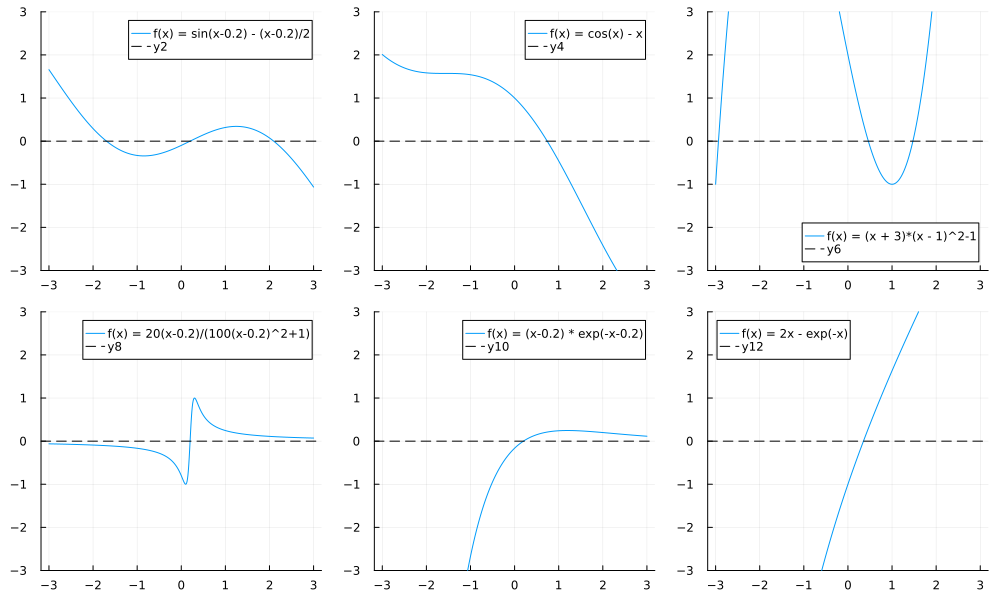

In [185]:
using Plots
default(titlefontsize=10, legendfontsize=8)

xs = -3:0.01:3

funcs = [
    ("f(x) = sin(x-0.2) - (x-0.2)/2", x -> sin(x-0.2) - (x-0.2)/2),
    ("f(x) = cos(x) - x", x -> cos(x) - x),
    ("f(x) = (x + 3)*(x - 1)^2-1", x -> (x + 3)*(x - 1)^2-1),
    ("f(x) = 20(x-0.2)/(100(x-0.2)^2+1)", x -> 20.0 * (x-0.2) / (100.0 * (x-0.2)^2 + 1.0)),
    ("f(x) = (x-0.2) * exp(-x-0.2)", x -> (x-0.2) * exp(-x-0.2)),
    ("f(x) = 2x - exp(-x)", x -> 2 * x - exp(-x))
]


plot(layout = (2, 3), size=(1000, 600))

for (i, (label, f)) in enumerate(funcs)
    ys = [try f(x) catch; NaN end for x in xs]
    plot!(xs, ys,ylims=(-3,3), subplot=i, label=label)
    hline!([0], linestyle=:dash, color=:black, subplot=i)
end

plot!()


#### Testy ilości iteracji

In [186]:
funcs = [
    ("f(x) = sin(x-0.2) - (x-0.2)/2", x -> sin(x-0.2) - (x-0.2)/2),
    ("f(x) = cos(x) - x", x -> cos(x) - x),
    ("f(x) = (x + 3)*(x - 1)^2-1", x -> (x + 3)*(x - 1)^2-1),
    ("f(x) = 20(x-0.2)/(100(x-0.2)^2+1)", x -> 20.0 * (x-0.2) / (100.0 * (x-0.2)^2 + 1.0)),
    ("f(x) = (x-0.2) * exp(-x-0.2)", x -> (x-0.2) * exp(-x-0.2)),
    ("f(x) = 2x - exp(-x)", x -> 2 * x - exp(-x))
]


df = DataFrame(What=String[], How=String[], Iters=Int[], Calls=Int[], Convergence=Float64[])

D(f) = x -> ForwardDiff.derivative(f, float(x))

bisection(f) = begin
    tracker = Roots.Tracks()
    val = find_zero(f, (0, 1), Bisection(), tracks = tracker)
    return tracker,val
end

newtonMethod(f) = begin
    tracker = Roots.Tracks()
    val = find_zero((f, D(f)), 0, Roots.Newton(), tracks = tracker)
    return tracker,val
end

steffenson(f) = begin
    tracker = Roots.Tracks()
    val = find_zero(f, 0, Order2(), tracks = tracker)
    return tracker,val
end

for (name, f) in funcs
    for (method_name, method_fun) in [("Bisection", bisection), ("Newton", newtonMethod), ("Steffenson", steffenson)]
        tracker,converge_to = method_fun(f)
        push!(df, (name, method_name, tracker.steps, tracker.fncalls, f(converge_to)))
    end
end

println(rpad("Funkcja", 35), rpad("Metoda", 15), rpad("Iteracje", 10), rpad("Wywołania", 10), "F(x_0)")
println("-"^100)

for i in 1:nrow(df)
    name = (i % 3 == 2) ? df.What[i] : ""
    println(rpad(name, 35), rpad(df.How[i], 15), rpad(string(df.Iters[i]), 10), rpad(string(df.Calls[i]),10),  df.Convergence[i])
    if i % 3 == 0
        println("-"^100)
    end
end



Funkcja                            Metoda         Iteracje  Wywołania F(x_0)
----------------------------------------------------------------------------------------------------
                                   Bisection      61        64        0.0
f(x) = sin(x-0.2) - (x-0.2)/2      Newton         3         6         0.0
                                   Steffenson     4         8         0.0
----------------------------------------------------------------------------------------------------
                                   Bisection      60        63        0.0
f(x) = cos(x) - x                  Newton         5         10        0.0
                                   Steffenson     6         10        0.0
----------------------------------------------------------------------------------------------------
                                   Bisection      61        64        -2.220446049250313e-16
f(x) = (x + 3)*(x - 1)^2-1         Newton         5         10        4.44089209850

#### Ciekawy przykład trudnej funkcji

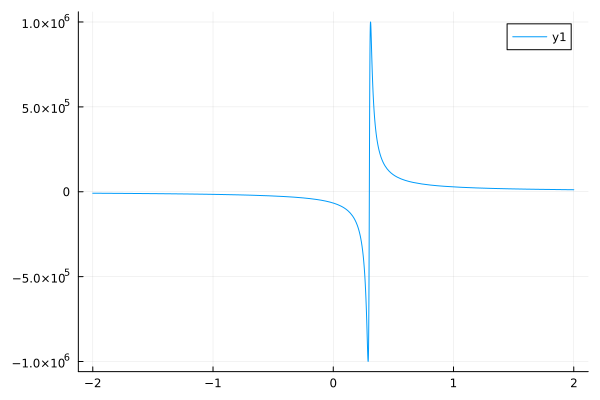

In [187]:
g(x) = 2e8 * (x - 0.3) / (10000 * (x - 0.3)^2 + 1)
xs = -2:2
plot(g, extrema(xs)...)

In [188]:
table = DataFrame(How=Function[],Iters=Float64[],Calls=Float64[])
tracker,val = bisection(g)
push!(table,(bisection, tracker.steps, tracker.fncalls))
tracker,val = newtonMethod(g)
push!(table,(newtonMethod,tracker.steps, tracker.fncalls))
tracker,val = steffenson(g)
push!(table,(steffenson, tracker.steps, tracker.fncalls))

Row,How,Iters,Calls
,Function,Float64,Float64
1,bisection,59.0,62.0
2,newtonMethod,34.0,68.0
3,steffenson,40.0,62.0


#### Funkcje dla których algorytmu nie działają

Steffenson

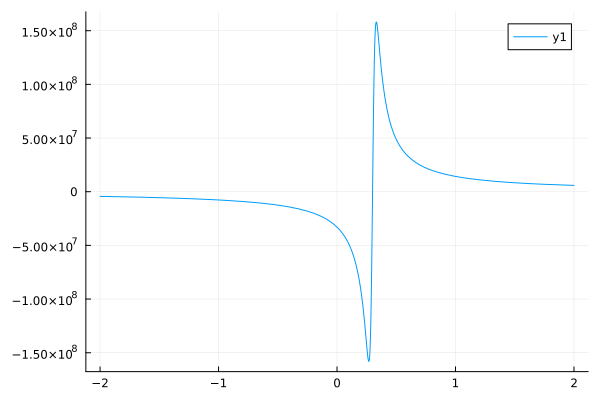

In [189]:
g(x) = 1e10 * (x - 0.3) / (1000 * (x - 0.3)^2 + 1)
xs = -2:2
plot(g, extrema(xs)...)

In [190]:
tracker,val = steffenson(g)

LoadError: Roots.ConvergenceFailed("Algorithm failed to converge")

Funkcja jest równa zero dla x = 0.3 ale z powodu liczenia `f(x + f(x))` argument może przyjmować duże wartości ($10^9 $) co uniemożliwia policzenie miejsca zerowego.

Newton

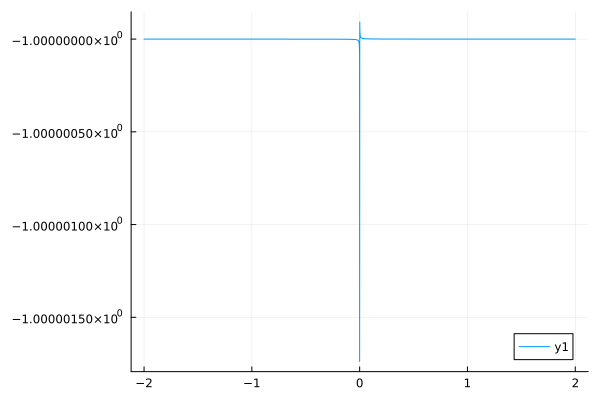

In [ ]:
g(x) = 1/(1e10*x) - 1
xs = -2:2
plot(g, extrema(xs)...)

In [ ]:
tracker,val = newtonMethod(g)

LoadError: Roots.ConvergenceFailed("Algorithm failed to converge")

Funkcja nie może policzyć miejsca zerowego dlatego że przy miejscu zerowym pochodna jest prkatycznie równa zero co daje efekt taki że:

$x_1 = x_0$

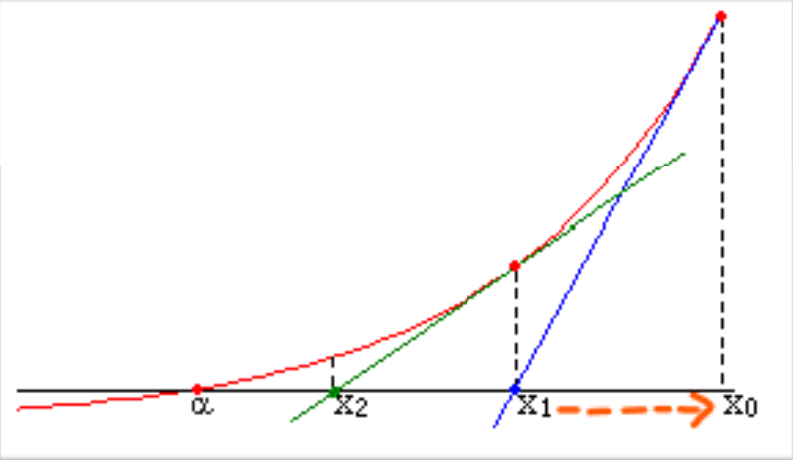

Newton 2.0

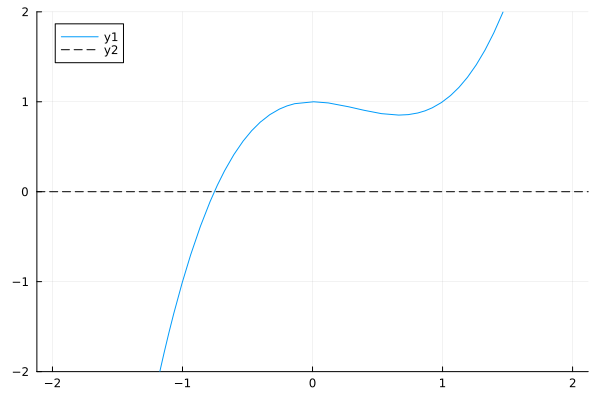

In [ ]:
g(x) = x^3-x^2+1
xs = -2:2
plot(g, extrema(xs)...,ylims=(-2,2))
hline!([0], linestyle=:dash, color=:black)

In [ ]:
tracker,val = newtonMethod(g)

LoadError: Roots.ConvergenceFailed("Algorithm failed to converge")

Gdy funkcja zaczyna szukać z pkt. np 0 to zbiega do `x=2/3` a tam nie ma miejsca zerowego

Bisekcja

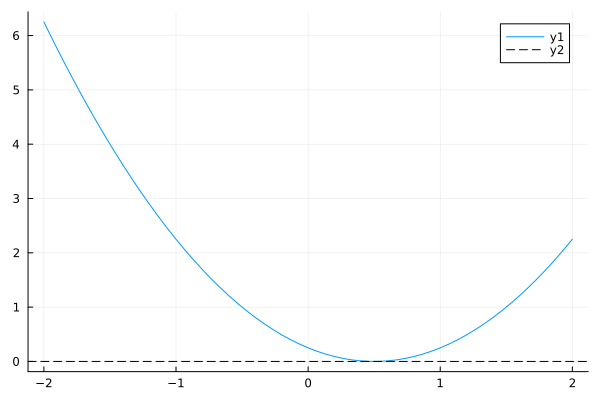

In [ ]:
g(x) = (x-0.5)^2
xs = -2:2
plot(g, extrema(xs)...)
hline!([0], linestyle=:dash, color=:black)

In [ ]:
tracker,val = bisection(g)

LoadError: ArgumentError: The interval [a,b] is not a bracketing interval.
You need f(a) and f(b) to have different signs (f(a) * f(b) < 0).
Consider a different bracket or try fzero(f, c) with an initial guess c.

